# Document Parsing with Qwen3-VL (Together AI)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Multimodal/Vision/Document_Parsing.ipynb)


## Introduction

In this notebook, we'll explore Qwen3-VL's document parsing capabilities using Together AI's API. We'll convert documents to structured formats:

1. **QwenVL HTML**: HTML with `<bbox>` attributes for element coordinates
2. **QwenVL Markdown**: Markdown with LaTeX tables and image placeholders

These capabilities are useful for document digitization, data extraction, and building RAG systems.


### Install required libraries


In [ ]:
!pip install together pillow beautifulsoup4 requests pydantic


In [1]:
import os
import re
import json
import base64
import requests
import together
from io import BytesIO
from typing import Optional
from pydantic import BaseModel, Field
from PIL import Image, ImageDraw, ImageFont
from bs4 import BeautifulSoup, Tag
from IPython.display import display, Markdown

# Together AI Configuration
client = together.Together()

MODEL_ID = "Qwen/Qwen3-VL-32B-Instruct"

print(f"Using model: {MODEL_ID}")
print(f"API Key configured: {bool(os.environ.get('TOGETHER_API_KEY'))}")


Using model: Qwen/Qwen3-VL-32B-Instruct
API Key configured: True


In [3]:
# Pydantic schemas for structured JSON output
class DocumentElement(BaseModel):
    """A single document element."""
    tag: str = Field(description="Element type (e.g. paragraph, heading, table, list_item, image)")
    text: str = Field(description="The text content of the element")
    bbox_2d: list[int] = Field(description="Bounding box coordinates [x1, y1, x2, y2] in normalized 0-1000 scale")

class DocumentParse(BaseModel):
    """List of document elements."""
    elements: list[DocumentElement] = Field(description="List of detected document elements")


# Utility functions
def encode_image(image_path):
    """Encode image to base64."""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def get_mime_type(image_path):
    """Get MIME type from file extension."""
    ext = image_path.split(".")[-1].lower()
    return "jpeg" if ext in ["jpg", "jpeg"] else ext

def inference_with_json_schema(image_path, prompt, schema: type[BaseModel], max_tokens=4096):
    """Run inference with Together AI API using JSON mode.
    
    Args:
        image_path: Path to the image file
        prompt: Text prompt for the model
        schema: Pydantic model class defining the expected output structure
        max_tokens: Maximum tokens to generate
    
    Returns:
        Parsed JSON dict matching the schema
    """
    base64_image = encode_image(image_path)
    mime_type = get_mime_type(image_path)
    
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[
            {
                "role": "system",
                "content": f"Analyze the document image and respond only in JSON following this schema: {json.dumps(schema.model_json_schema())}",
            },
            {
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/{mime_type};base64,{base64_image}"}},
                    {"type": "text", "text": prompt},
                ],
            }
        ],
        max_tokens=max_tokens,
        response_format={
            "type": "json_schema",
            "schema": schema.model_json_schema(),
        },
    )
    
    return json.loads(response.choices[0].message.content)

def draw_bbox_json(image_path, detections):
    """Visualize document elements from JSON detections."""
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    
    width, height = image.size
    draw = ImageDraw.Draw(image)
    
    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 10)
    except:
        font = ImageFont.load_default()
    
    for element in detections:
        text = element.get('text', '')[:30]
        bbox = element.get('bbox_2d')
        if not bbox or len(bbox) != 4:
            continue
            
        bx1 = int(bbox[0] / 1000 * width)
        by1 = int(bbox[1] / 1000 * height)
        bx2 = int(bbox[2] / 1000 * width)
        by2 = int(bbox[3] / 1000 * height)
        
        if bx1 > bx2: bx1, bx2 = bx2, bx1
        if by1 > by2: by1, by2 = by2, by1
            
        draw.rectangle([bx1, by1, bx2, by2], outline='red', width=2)
        draw.text((bx1, by2), text, fill='black', font=font)

    display(image)



## 1. Document Parsing with JSON Mode

Extract structured document elements with their bounding boxes and text content.


JSON Output (first 5 elements):
[
  {
    "tag": "heading",
    "text": "Company Background",
    "bbox_2d": [
      55,
      59,
      389,
      107
    ]
  },
  {
    "tag": "paragraph",
    "text": "Industry: Specialty pharmaceuticals (Orphan drugs for narcolepsy, leukemia, and stem-cell complications)",
    "bbox_2d": [
      74,
      174,
      877,
      205
    ]
  },
  {
    "tag": "paragraph",
    "text": "LTM Financials: $1.5 billion revenue; $759 million EBITDA",
    "bbox_2d": [
      74,
      223,
      536,
      255
    ]
  },
  {
    "tag": "paragraph",
    "text": "Market Cap: $9.1 billion; Enterprise Value: $10.5 billion",
    "bbox_2d": [
      74,
      274,
      515,
      306
    ]
  },
  {
    "tag": "paragraph",
    "text": "LTM Multiples: 6.8x EV / Revenue; 13.8x EV / EBITDA",
    "bbox_2d": [
      74,
      325,
      510,
      357
    ]
  }
]


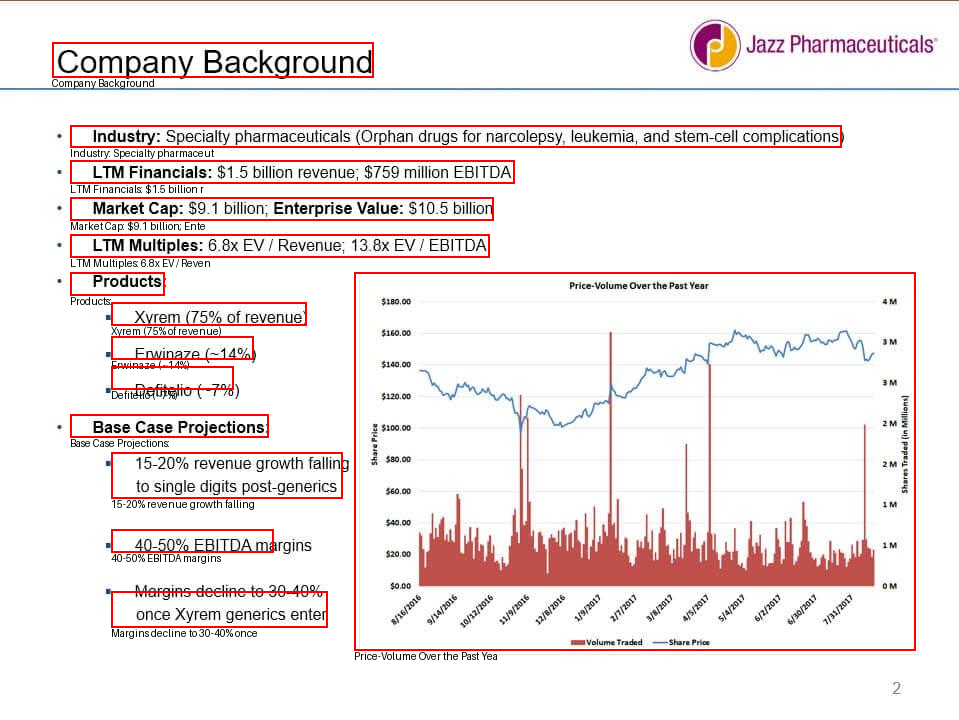

In [5]:
# Download and save sample image
img_url = "https://mi-uploads-live.s3.amazonaws.com/wp-content/uploads/2019/04/22071151/Jazz-Company-Background.jpg"
img_name = "sample_doc.jpg"

response = requests.get(img_url)
image = Image.open(BytesIO(response.content))
image.save(img_name)

prompt = "Extract all document elements including headings, paragraphs, and list items with their bounding boxes."

result = inference_with_json_schema(img_name, prompt, DocumentParse)
print("JSON Output (first 5 elements):")
print(json.dumps(result['elements'][:5], indent=2))

draw_bbox_json(img_name, result['elements'])


## 2. Structured Data Extraction

Extract complex document structures like tables or key-value pairs using custom JSON schemas.


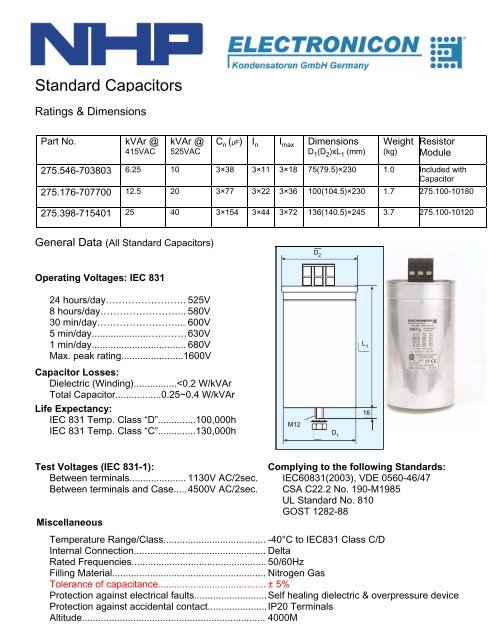

Extracted Table Data:
{
  "table_name": "Standard Capacitors Ratings & Dimensions",
  "rows": [
    {
      "cells": [
        {
          "text": "Part No.",
          "is_header": true
        },
        {
          "text": "kVAr @ 415VAC",
          "is_header": true
        },
        {
          "text": "kVAr @ 525VAC",
          "is_header": true
        },
        {
          "text": "Cn (\u03bcF)",
          "is_header": true
        },
        {
          "text": "In",
          "is_header": true
        },
        {
          "text": "Imax",
          "is_header": true
        },
        {
          "text": "Dimensions D1(D2)xL (mm)",
          "is_header": true
        },
        {
          "text": "Weight (kg)",
          "is_header": true
        },
        {
          "text": "Resistor Module",
          "is_header": true
        }
      ]
    },
    {
      "cells": [
        {
          "text": "275.546-703803",
          "is_header": false
        },
        {
       

### Standard Capacitors Ratings & Dimensions

| Part No. | kVAr @ 415VAC | kVAr @ 525VAC | Cn (μF) | In | Imax | Dimensions D1(D2)xL (mm) | Weight (kg) | Resistor Module |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 275.546-703803 | 6.25 | 10 | 3×36 | 3×11 | 3×18 | 75(79.5)×230 | 1.0 | Included with Capacitor |
| 275.176-707700 | 12.5 | 20 | 3×77 | 3×22 | 3×36 | 100(104.5)×230 | 1.7 | 275.100-10160 |
| 275.398-715401 | 25 | 40 | 3×154 | 3×44 | 3×72 | 136(140.5)×245 | 3.7 | 275.100-10120 |


In [8]:
# Define a schema for table extraction
class TableCell(BaseModel):
    text: str
    is_header: bool

class TableRow(BaseModel):
    cells: list[TableCell]

class TableExtraction(BaseModel):
    table_name: str
    rows: list[TableRow]

# Download and save sample image
img_url = "https://img.yumpu.com/4781250/1/500x640/electronicon-capacitor-datasheet-nhp.jpg"
img_name = "sample_table.jpg"

# Display the image as well
from IPython.display import display
response = requests.get(img_url)
image = Image.open(BytesIO(response.content))
display(image)

response = requests.get(img_url)
image = Image.open(BytesIO(response.content))
image.save(img_name)

prompt = "Extract the table from this image into a structured JSON format."

result = inference_with_json_schema(img_name, prompt, TableExtraction)
print("Extracted Table Data:")
print(json.dumps(result, indent=2))

# Helper to display as Markdown table
md_table = f"### {result['table_name']}\n\n"
for row in result['rows']:
    md_table += "| " + " | ".join([cell['text'] for cell in row['cells']]) + " |\n"
    if any(cell['is_header'] for cell in row['cells']):
        md_table += "| " + " | ".join(["---" for _ in row['cells']]) + " |\n"

display(Markdown(md_table))
